In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline
sns.set_style('whitegrid')

In [106]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [107]:
loans = select('SELECT * FROM LOAN_FINAL')
loans = loans.drop('index',axis=1)

In [108]:
# separating the data into the first general problem at hand: "Completed Loans" 

loans = loans[(loans['loan_status']=='Charged Off') | (loans['loan_status']=='Fully Paid')].copy()
features = loans.drop('loan_status',axis=1).copy()
targets = loans['loan_status'].copy()

In [109]:
# split up features into numerical and non-numerical values

numerical = []
strings = []

for i in range(len(loans.dtypes)):
    if (loans.dtypes[i] == 'int64') or (loans.dtypes[i] == 'float64'):
        numerical = numerical + [loans.dtypes.index[i]]
        
    if (loans.dtypes[i] == 'O') and (loans.dtypes.index[i]!='loan_status'):
        strings = strings + [loans.dtypes.index[i]]

In [110]:
numerical_all = list(numerical)

In [112]:
# contain NaN values need to figure out how to translate the meaning implied by NaN in these columns
# member_id has no predictive value
# removing features containing values which may not be known at time of loan origination (otherwise problem is trivial)
# last three are unnecessary from this problem's standpoint

numerical_all.remove('mths_since_last_delinq')
numerical_all.remove('mths_since_last_major_derog')
numerical_all.remove('member_id')

numerical.remove('mths_since_last_delinq')
numerical.remove('mths_since_last_major_derog')
numerical.remove('member_id')
numerical.remove('delinq_2yrs')
numerical.remove('inq_last_6mths')
numerical.remove('out_prncp')
numerical.remove('out_prncp_inv')
numerical.remove('total_pymnt')
numerical.remove('total_pymnt_inv')
numerical.remove('total_rec_prncp')
numerical.remove('total_rec_int')
numerical.remove('total_rec_late_fee')
numerical.remove('recoveries')
numerical.remove('collection_recovery_fee')
numerical.remove('last_pymnt_amnt')
numerical.remove('collections_12_mths_ex_med')
numerical.remove('tot_coll_amt')
numerical.remove('mths_since_issue')
numerical.remove('mths_left')
numerical.remove('%_term_completed')

In [116]:
print(numerical)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'policy_code', 'acc_now_delinq']


In [113]:
outputmap = {'Charged Off':0,'Fully Paid':1}
targets = targets.apply(lambda x: outputmap[x])

In [114]:
# baseline score using limited features--only those which could be known at time of loan origination

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

features_train, features_test, targets_train, targets_test = \
    train_test_split(features[numerical],targets,random_state=10,test_size=0.2)

lr = LogisticRegression()
lr.fit(features_train[numerical],targets_train)
accuracy_score(lr.predict(features_test[numerical]),targets_test)

0.82104866237993168

In [115]:
# performs ridiculously well when using all features. need to strip away those that give obvious
# 'hints' to our model about whether the loan will be charged off. (e.g. recoveries, collection recovery fee, etc..)
# use random_state to ensure same data is used in training/test

features_train, features_test, targets_train, targets_test = \
    train_test_split(features[numerical_all],targets,random_state=10,test_size=0.2)

lr2 = LogisticRegression()
lr2.fit(features_train[numerical_all],targets_train)
accuracy_score(lr2.predict(features_test[numerical_all]),targets_test)
accuracy_score(lr2.predict(features_test[numerical_all]),targets_test)

0.99773755656108598

Text(0.5,0,'dti')

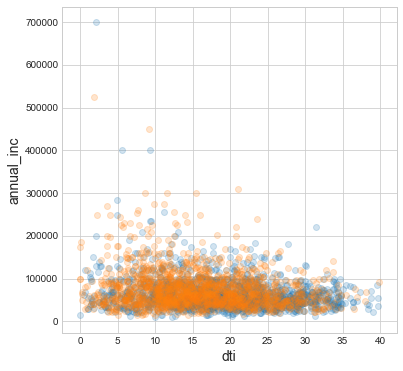

In [158]:
# no two features alone seem to give reliable predictive utility.. orange/blue points are always intermeshed

features = ['dti','annual_inc']

charged_off_sample = loans[loans.loan_status=='Charged Off'][features].sample(1500)
fully_paid_sample = loans[loans.loan_status=='Fully Paid'][features].sample(1500)

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.scatter(charged_off_sample.dti,charged_off_sample.annual_inc,alpha=0.2)
ax.scatter(fully_paid_sample.dti,fully_paid_sample.annual_inc,alpha=0.2)
ax.set_ylabel(features[1],fontsize=14)
ax.set_xlabel(features[0],fontsize=14)